Found 945 images belonging to 2 classes.
Found 464 images belonging to 2 classes.
Epoch 1/15
60/60 [==============================] - 17s 109ms/step - loss: 0.7489 - accuracy: 0.5566 - val_loss: 0.6298 - val_accuracy: 0.6034
Epoch 2/15
60/60 [==============================] - 5s 82ms/step - loss: 0.6609 - accuracy: 0.6275 - val_loss: 0.6007 - val_accuracy: 0.6487
Epoch 3/15
60/60 [==============================] - 4s 74ms/step - loss: 0.6393 - accuracy: 0.6455 - val_loss: 0.5983 - val_accuracy: 0.6466
Epoch 4/15
60/60 [==============================] - 5s 90ms/step - loss: 0.6201 - accuracy: 0.6688 - val_loss: 0.5810 - val_accuracy: 0.6703
Epoch 5/15
60/60 [==============================] - 5s 90ms/step - loss: 0.5830 - accuracy: 0.6889 - val_loss: 0.5684 - val_accuracy: 0.6875
Epoch 6/15
60/60 [==============================] - 5s 77ms/step - loss: 0.5779 - accuracy: 0.6931 - val_loss: 0.5688 - val_accuracy: 0.6746
Epoch 7/15
60/60 [==============================] - 5s 80ms/step - los

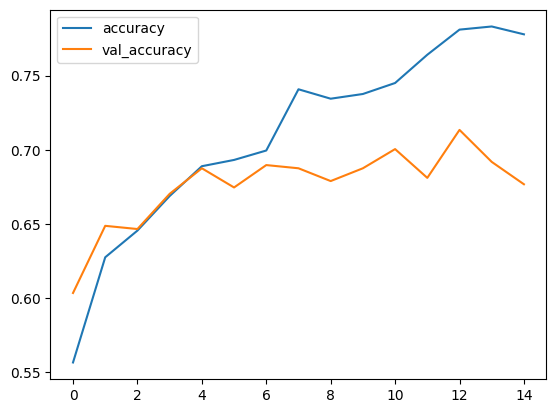

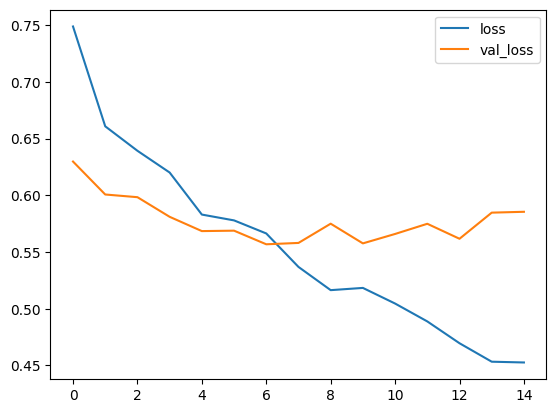

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import glob
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import seaborn as sns
import pandas as pd

def create_resnet_model():
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),  # Ajuste para manter consistência
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

    return model

def plot_metrics(history):
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot()
    plt.show()
    df[['loss', 'val_loss']].plot()
    plt.show()

def save_classification_report(filename, report):
    with open(filename, 'w') as file:
        file.write(f'tempo {report}')

def plot_confusion_matrix(cm, labels):
    cm_df = pd.DataFrame(cm, columns=labels, index=labels)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True)
    plt.show()

def main():
    NAME = f"Tcc_cnn_64_{int(time.time())}"

    all_training_paths = glob.glob('DATASETS/TRAINING/*/*.jpg')
    all_validation_paths = glob.glob('DATASETS/VALIDATION/*/*.jpg')

    datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = datagen_resnet.flow_from_directory('DATASETS/TRAINING/',
                                                   target_size=(224, 224),
                                                   class_mode="categorical",
                                                   batch_size=16
                                                   )

    validation_gen = datagen_resnet.flow_from_directory('DATASETS/VALIDATION/',
                                                        target_size=(224, 224),
                                                        class_mode="categorical",
                                                        batch_size=16
                                                        )

 

    # Configurar o ModelCheckpoint
       # Configurar o ModelCheckpoint com o número da época no nome do arquivo
    checkpoint = ModelCheckpoint('best_model_epoch_{epoch:02d}.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 mode='max'
                                )
    
        # Configurar o EarlyStopping para interromper o treinamento se não houver melhoria na métrica monitorada
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=5,  # Número de épocas sem melhoria antes de parar
                                   restore_best_weights=True
                                  )
    
    tensor_board = TensorBoard(log_dir=f'logs/{NAME}')

    model = create_resnet_model()

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )

    history = model.fit(train_gen,
                        validation_data=validation_gen,
                        epochs=15,
                        batch_size=16,
                        callbacks=[tensor_board, checkpoint, early_stopping]
                        )

    plot_metrics(history)
    
    

if __name__ == "__main__":
    main()
    


In [ ]:
# salvan modelo
model.save('best_model_epoch_best.h5')

In [76]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Criação do gerador de dados para o conjunto de teste
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = datagen_resnet.flow_from_directory('DATASETS/TESTING/',
                                              target_size=(224, 224),
                                              class_mode="categorical",
                                              batch_size=16
                                              )

# Carrega o melhor modelo salvo após o treinamento
best_model = tf.keras.models.load_model('best_model_epoch_best.h5')

# Faz previsões no conjunto de teste
predictions = best_model.predict(test_gen, verbose=1)

# Obtém as classes preditas e as classes verdadeiras
y_pred = np.argmax(predictions, axis=-1)
y_test = test_gen.labels

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Calcula e imprime o relatório de classificação
classification_rep = classification_report(test_gen.classes, y_pred)
print("Relatório de Classificação:")
print(classification_rep)

# Salva o relatório de classificação em um arquivo (opcional, você pode remover esta linha)
# save_classification_report('time_bin_metrics.txt', classification_rep)

# Plota a matriz de confusão (opcional, você pode remover esta linha)
# plot_confusion_matrix(cm, ['cancer', 'no cancer'])

# Interpretando a matriz de confusão
TP = cm[0, 0]  # Verdadeiro Positivo
TN = cm[1, 0]  # Verdadeiro Negativo
FP = cm[0, 1]  # Falso Positivo
FN = cm[1, 1]  # Falso Negativo

# Imprime as métricas de desempenho
print(f"\nAcertou na classificação com cancer  (TP): {TP}")
print(f"Errou na classificação com cancer : {TN}")
print(f"Errou na classificação sem cancer: {FP}")
print(f"Acertou na classificação sem cancer: {FN}")

Found 146 images belonging to 2 classes.


10/10 [==============================] - 1s 75ms/step
Matriz de Confusão:
[[44 29]
 [33 40]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.57      0.60      0.59        73
           1       0.58      0.55      0.56        73

    accuracy                           0.58       146
   macro avg       0.58      0.58      0.58       146
weighted avg       0.58      0.58      0.58       146


Acertou na classificação com cancer  (TP): 44
Errou na classificação com cancer : 33
Errou na classificação sem cancer: 29
Acertou na classificação sem cancer: 40


In [77]:
modelo_op = tf.keras.models.load_model('best_model_epoch_best.h5')
predictions = modelo_op.predict(test_gen, verbose=1)

10/10 [==============================] - 1s 72ms/step


In [78]:
def predicao(modelo, path):
    image = Image.open(path)

# Redimensione a imagem
    resized_image = image.resize((224, 224))

    # Certifique-se de que a imagem seja colorida (3 canais)
    if resized_image.mode == 'L':
        # Converta a imagem em escala de cinza em uma imagem RGB (colorida)
        resized_image = resized_image.convert('RGB')

    # Converta a imagem redimensionada em uma matriz NumPy
    np_array = np.array(resized_image)

    
    img_np = preprocess_input(np_array)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo_op.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in test_gen.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(resized_image)
    plt.show()

DATASETS/TESTING\WITHOUT-CANCER\2-290.jpg
1/1 [==============================] - 0s 23ms/step


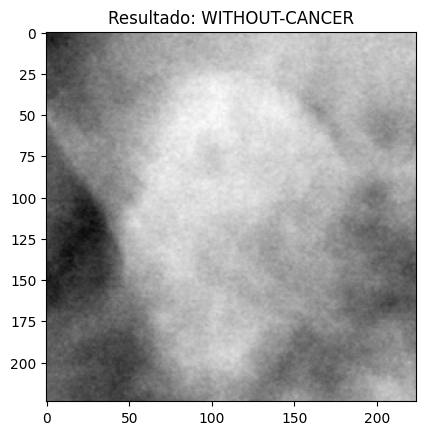

DATASETS/TESTING\WITHOUT-CANCER\2-297 (2).jpg
1/1 [==============================] - 0s 21ms/step


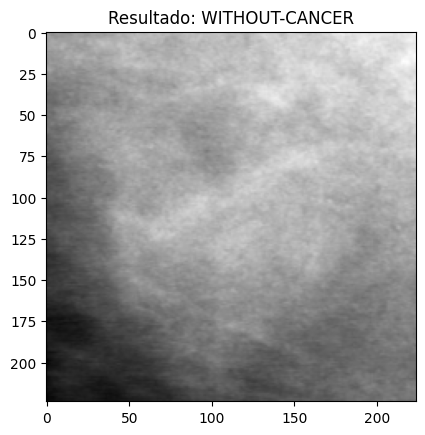

DATASETS/TESTING\WITHOUT-CANCER\2-233 (1).jpg
1/1 [==============================] - 0s 22ms/step


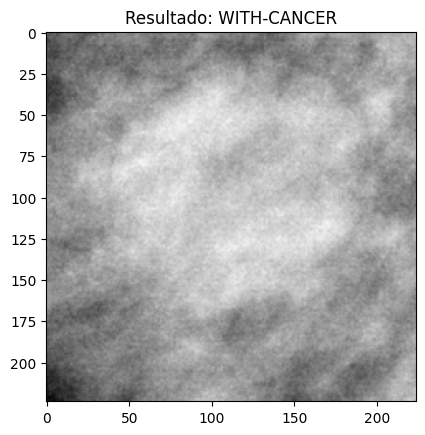

DATASETS/TESTING\WITHOUT-CANCER\2-281.jpg
1/1 [==============================] - 0s 23ms/step


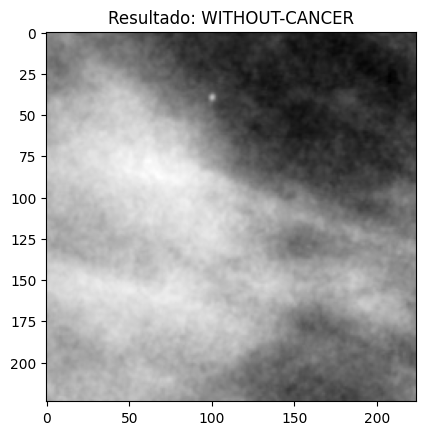

DATASETS/TESTING\WITH-CANCER\2-287.jpg
1/1 [==============================] - 0s 29ms/step


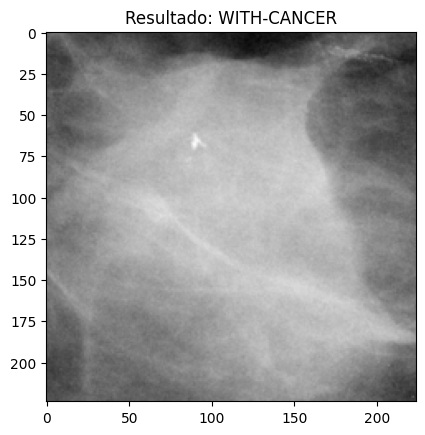

DATASETS/TESTING\WITHOUT-CANCER\2-233.jpg
1/1 [==============================] - 0s 21ms/step


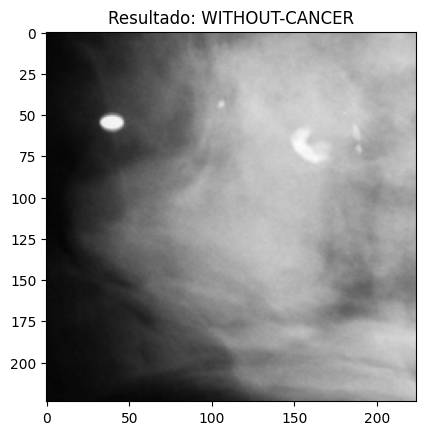

DATASETS/TESTING\WITH-CANCER\2-281.jpg
1/1 [==============================] - 0s 19ms/step


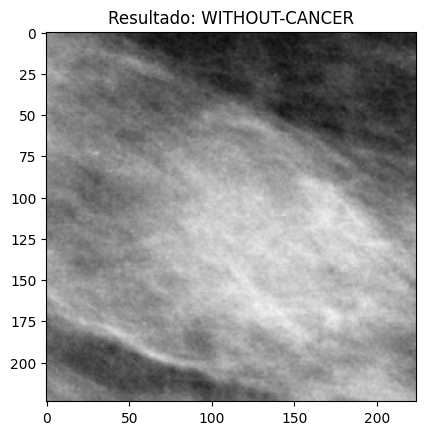

DATASETS/TESTING\WITHOUT-CANCER\2-267.jpg
1/1 [==============================] - 0s 27ms/step


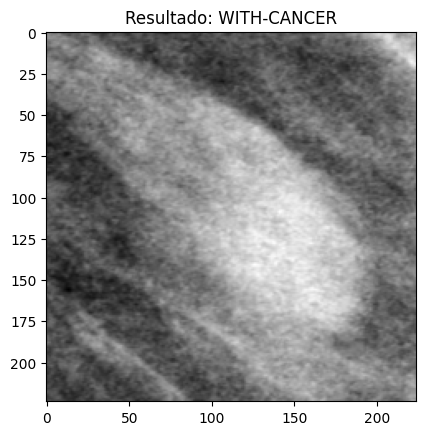

In [81]:
import random
# pegando 10 cminhos aliatorios para predição e moreando o resultado
all_test_paths = glob.glob('DATASETS/TESTING/*/*.jpg')
for i in range(8):
    img_path=random.choice(all_test_paths)
    print(img_path)
    predicao(modelo_op, img_path)